In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity

In [39]:
def img_preprocess(img):
    img = cv2.resize(img, (500, 500))
    
    return img

def img_show(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

def show_side_by_side(img_1, img_2, titulo1="Imagem 1", titulo2="Imagem 2"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img_1, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(titulo1)

    axs[1].imshow(img_2, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(titulo2)

    plt.show()
    

In [71]:
from skimage import restoration


def total_variation_denoise(img1):
  return restoration.denoise_tv_chambolle(img1, weight=0.1, channel_axis=-1)

In [68]:
from scipy.spatial import distance
from scipy.ndimage import convolve
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve

def get_sparse_neighbor(p: int, n: int, m: int):
    """Returns a dictionnary, where the keys are index of 4-neighbor of `p` in the sparse matrix,
       and values are tuples (i, j, x), where `i`, `j` are index of neighbor in the normal matrix,
       and x is the direction of neighbor.

    Arguments:
        p {int} -- index in the sparse matrix.
        n {int} -- number of rows in the original matrix (non sparse).
        m {int} -- number of columns in the original matrix.

    Returns:
        dict -- dictionnary containing indices of 4-neighbors of `p`.
    """
    i, j = p // m, p % m
    d = {}
    if i - 1 >= 0:
        d[(i - 1) * m + j] = (i - 1, j, 0)
    if i + 1 < n:
        d[(i + 1) * m + j] = (i + 1, j, 0)
    if j - 1 >= 0:
        d[i * m + j - 1] = (i, j - 1, 1)
    if j + 1 < m:
        d[i * m + j + 1] = (i, j + 1, 1)
    return d


def create_spacial_affinity_kernel(spatial_sigma: float, size: int = 15):
    """Create a kernel (`size` * `size` matrix) that will be used to compute the he spatial affinity based Gaussian weights.

    Arguments:
        spatial_sigma {float} -- Spatial standard deviation.

    Keyword Arguments:
        size {int} -- size of the kernel. (default: {15})

    Returns:
        np.ndarray - `size` * `size` kernel
    """
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            kernel[i, j] = np.exp(-0.5 * (distance.euclidean((i, j), (size // 2, size // 2)) ** 2) / (spatial_sigma ** 2))

    return kernel


def compute_smoothness_weights(L: np.ndarray, x: int, kernel: np.ndarray, eps: float = 1e-3):
    """Compute the smoothness weights used in refining the illumination map optimization problem.

    Arguments:
        L {np.ndarray} -- the initial illumination map to be refined.
        x {int} -- the direction of the weights. Can either be x=1 for horizontal or x=0 for vertical.
        kernel {np.ndarray} -- spatial affinity matrix

    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability. (default: {1e-3})

    Returns:
        np.ndarray - smoothness weights according to direction x. same dimension as `L`.
    """
    Lp = cv2.Sobel(L, cv2.CV_64F, int(x == 1), int(x == 0), ksize=1)
    T = convolve(np.ones_like(L), kernel, mode='constant')
    T = T / (np.abs(convolve(Lp, kernel, mode='constant')) + eps)
    return T / (np.abs(Lp) + eps)


def fuse_multi_exposure_images(im: np.ndarray, under_ex: np.ndarray, over_ex: np.ndarray,
                               bc: float = 1, bs: float = 1, be: float = 1):
    """perform the exposure fusion method used in the DUAL paper.

    Arguments:
        im {np.ndarray} -- input image to be enhanced.
        under_ex {np.ndarray} -- under-exposure corrected image. same dimension as `im`.
        over_ex {np.ndarray} -- over-exposure corrected image. same dimension as `im`.

    Keyword Arguments:
        bc {float} -- parameter for controlling the influence of Mertens's contrast measure. (default: {1})
        bs {float} -- parameter for controlling the influence of Mertens's saturation measure. (default: {1})
        be {float} -- parameter for controlling the influence of Mertens's well exposedness measure. (default: {1})

    Returns:
        np.ndarray -- the fused image. same dimension as `im`.
    """
    merge_mertens = cv2.createMergeMertens(bc, bs, be)
    images = [np.clip(x * 255, 0, 255).astype("uint8") for x in [im, under_ex, over_ex]]
    fused_images = merge_mertens.process(images)
    return fused_images


def refine_illumination_map_linear(L: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    """Refine the illumination map based on the optimization problem described in the two papers.
       This function use the sped-up solver presented in the LIME paper.

    Arguments:
        L {np.ndarray} -- the illumination map to be refined.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem.
        kernel {np.ndarray} -- spatial affinity matrix.

    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability (default: {1e-3}).

    Returns:
        np.ndarray -- refined illumination map. same shape as `L`.
    """
    # compute smoothness weights
    wx = compute_smoothness_weights(L, x=1, kernel=kernel, eps=eps)
    wy = compute_smoothness_weights(L, x=0, kernel=kernel, eps=eps)

    n, m = L.shape
    L_1d = L.copy().flatten()

    # compute the five-point spatially inhomogeneous Laplacian matrix
    row, column, data = [], [], []
    for p in range(n * m):
        diag = 0
        for q, (k, l, x) in get_sparse_neighbor(p, n, m).items():
            weight = wx[k, l] if x else wy[k, l]
            row.append(p)
            column.append(q)
            data.append(-weight)
            diag += weight
        row.append(p)
        column.append(p)
        data.append(diag)
    F = csr_matrix((data, (row, column)), shape=(n * m, n * m))

    # solve the linear system
    Id = diags([np.ones(n * m)], [0])
    A = Id + lambda_ * F
    L_refined = spsolve(csr_matrix(A), L_1d, permc_spec=None, use_umfpack=True).reshape((n, m))

    # gamma correction
    L_refined = np.clip(L_refined, eps, 1) ** gamma

    return L_refined


def correct_underexposure(im: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    """correct underexposudness using the retinex based algorithm presented in DUAL and LIME paper.

    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem.
        kernel {np.ndarray} -- spatial affinity matrix.

    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability (default: {1e-3})

    Returns:
        np.ndarray -- image underexposudness corrected. same shape as `im`.
    """

    # first estimation of the illumination map
    L = np.max(im, axis=-1)
    # illumination refinement
    L_refined = refine_illumination_map_linear(L, gamma, lambda_, kernel, eps)

    # correct image underexposure
    L_refined_3d = np.repeat(L_refined[..., None], 3, axis=-1)
    im_corrected = im / L_refined_3d
    return im_corrected

# TODO: resize image if too large, optimization take too much time


def enhance_image_exposure(im: np.ndarray, gamma: float, lambda_: float, dual: bool = True, sigma: int = 3,
                           bc: float = 1, bs: float = 1, be: float = 1, eps: float = 1e-3):
    """Enhance input image, using either DUAL method, or LIME method. For more info, please see original papers.

    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem (in DUAL and LIME).

    Keyword Arguments:
        dual {bool} -- boolean variable to indicate enhancement method to be used (either DUAL or LIME) (default: {True})
        sigma {int} -- Spatial standard deviation for spatial affinity based Gaussian weights. (default: {3})
        bc {float} -- parameter for controlling the influence of Mertens's contrast measure. (default: {1})
        bs {float} -- parameter for controlling the influence of Mertens's saturation measure. (default: {1})
        be {float} -- parameter for controlling the influence of Mertens's well exposedness measure. (default: {1})
        eps {float} -- small constant to avoid computation instability (default: {1e-3})

    Returns:
        np.ndarray -- image exposure enhanced. same shape as `im`.
    """
    # create spacial affinity kernel
    kernel = create_spacial_affinity_kernel(sigma)

    # correct underexposudness
    im_normalized = im.astype(float) / 255.
    under_corrected = correct_underexposure(im_normalized, gamma, lambda_, kernel, eps)

    if dual:
        # correct overexposure and merge if DUAL method is selected
        inv_im_normalized = 1 - im_normalized
        over_corrected = 1 - correct_underexposure(inv_im_normalized, gamma, lambda_, kernel, eps)
        # fuse images
        im_corrected = fuse_multi_exposure_images(im_normalized, under_corrected, over_corrected, bc, bs, be)
    else:
        im_corrected = under_corrected

    # convert to 8 bits and returns
    return np.clip(im_corrected * 255, 0, 255).astype("uint8")

def lime_filter(img):
    img = enhance_image_exposure(img, gamma=0.6, lambda_=0.15)
    
    return img


In [41]:
def bilateral_filter(img):
    result = cv2.bilateralFilter(img, 9, 75, 75)
    
    return result

In [94]:
import sys
PY3 = sys.version_info > (3,)
if PY3:
    from builtins import isinstance


def compute_weights(images, time_decay):
    (w_c, w_s, w_e) = (1, 1, 1)

    if time_decay is not None:
        tau = len(images)
        sigma2 = (tau**2)/(np.float32(time_decay)**2)
        t = np.array(range(tau-1, -1, -1))
        decay = np.exp(-((t)**2)/(2*sigma2))

    weights = []
    weights_sum = np.zeros(images[0].shape[:2], dtype=np.float32)
    i = 0
    for image_uint in images:
        image = np.float32(image_uint)/255
        W = np.ones(image.shape[:2], dtype=np.float32)

        # contrast
        image_gray = image
        laplacian = cv2.Laplacian(image_gray, cv2.CV_32F)
        W_contrast = np.absolute(laplacian) ** w_c + 1
        W = np.multiply(W, W_contrast)

        # saturation
        W_saturation = image.std(axis=2, dtype=np.float32) ** w_s + 1
        W = np.multiply(W, W_saturation)

        # well-exposedness
        sigma2 = 0.4
        W_exposedness = np.prod(np.exp(-((image - 0.5)**2)/(2*sigma2)), axis=2, dtype=np.float32) ** w_e + 1
        W = np.multiply(W, W_exposedness)

        if time_decay is not None:
            W *= decay[i]
            i += 1

        weights_sum += W

        weights.append(W)

    # normalization
    nonzero = weights_sum > 0
    for i in range(len(weights)):
        weights[i][nonzero] /= weights_sum[nonzero]
        weights[i] = np.uint8(weights[i]*255)

    return weights


def gaussian_kernel(size=5, sigma=0.4):
    return cv2.getGaussianKernel(ksize=size, sigma=sigma)


def image_reduce(image):
    kernel = gaussian_kernel()
    out_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    out_image = cv2.resize(out_image, None, fx=0.5, fy=0.5)
    return out_image


def image_expand(image):
    kernel = gaussian_kernel()
    out_image = cv2.resize(image, None, fx=2, fy=2)
    out_image = cv2.filter2D(out_image, cv2.CV_8UC3, kernel)
    return out_image


def gaussian_pyramid(img, depth):
    G = img.copy()
    gp = [G]
    for i in range(depth):
        G = image_reduce(G)
        gp.append(G)
    return gp


def laplacian_pyramid(img, depth):
    gp = gaussian_pyramid(img, depth+1)
    lp = [gp[depth-1]]
    for i in range(depth-1, 0, -1):
        GE = image_expand(gp[i])
        L = cv2.subtract(gp[i-1], GE)
        lp = [L] + lp
    return lp


def pyramid_collapse(pyramid):
    depth = len(pyramid)
    collapsed = pyramid[depth-1]
    for i in range(depth-2, -1, -1):
        collapsed = cv2.add(image_expand(collapsed), pyramid[i])
    return collapsed


def exposure_fusion(images, depth=3, time_decay=None):

    if not isinstance(images, list) or len(images) < 2:
        print("Input has to be a list of at least two images")
        return None

    size = images[0].shape
    for i in range(len(images)):
        if not images[i].shape == size:
            print("Input images have to be of the same size")
            return None

    # compute weights
    weights = compute_weights(images, time_decay)

    # compute pyramids
    lps = []
    gps = []
    for (image, weight) in zip(images, weights):
        lps.append(laplacian_pyramid(image, depth))
        gps.append(gaussian_pyramid(weight, depth))

    # combine pyramids with weights
    LS = []
    for l in range(depth):
        ls = np.zeros(lps[0][l].shape, dtype=np.uint8)
        for k in range(len(images)):
            lp = lps[k][l]
            gps_float = np.float32(gps[k][l])/255
            gp = np.dstack((gps_float, gps_float, gps_float))
            lp_gp = cv2.multiply(lp, gp, dtype=cv2.CV_8UC3)
            ls = cv2.add(ls, lp_gp)
        LS.append(ls)

    # collapse pyramid
    fusion = pyramid_collapse(LS)
    return fusion


def align_images(images):

    if not isinstance(images, list) or len(images) < 2:
        print("Input has to be a list of at least two images")
        return None

    size = images[0].shape
    for i in range(len(images)):
        if not images[i].shape == size:
            print("Input images have to be of the same size")
            return None

    # Convert images to grayscale
    gray_images = []
    for image in images:
        gray_images.append(image)

    model_image = gray_images[0]

    # Find size of images
    sz = model_image.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000

    # Specify the threshold of the increment in the correlation coefficient between two iterations
    termination_eps = 1e-10

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    aligned_images = [images[0]]
    for i in range(1, len(images)):
        (cc, warp_matrix) = cv2.findTransformECC(model_image, gray_images[i], warp_matrix, warp_mode, criteria, inputMask=None, gaussFiltSize=3)

        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            # Use warpPerspective for Homography
            aligned_image = cv2.warpPerspective (images[i], warp_matrix, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else:
            # Use warpAffine for Translation, Euclidean and Affine
            aligned_image = cv2.warpAffine(images[i], warp_matrix, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        aligned_images.append(aligned_image)

    return aligned_images

def exposure_fusion_filter(img):
    images = [img]

    for i in range(2,134):
        other_image = cv2.imread(f'../DATA/raw/normal/normal ({i}).png', cv2.IMREAD_GRAYSCALE)
        other_image = img_preprocess(other_image)
        images.append(other_image)

    return exposure_fusion(align_images(images), depth=3)[0]

In [104]:
def median_blur(img):
    return cv2.medianBlur(img, 5)

def gaussian_blur(img):
    return cv2.GaussianBlur(img, (9, 9), 0)


In [42]:
def evaulate_rmse(imagem1, imagem2):
    if imagem1.shape != imagem2.shape:
        raise ValueError("As imagens têm dimensões diferentes.")

    # Calcular o erro quadrático entre as imagens
    erro_quadratico = np.square(imagem1.astype(np.float32) - imagem2.astype(np.float32))

    # Calcular o RMSE
    rmse = np.sqrt(np.mean(erro_quadratico))

    return rmse

def evaluate_ambe(imagem1, imagem2):
    # Verificar se as imagens têm as mesmas dimensões
    if imagem1.shape != imagem2.shape:
        raise ValueError("As imagens têm dimensões diferentes.")

    # Calcular a diferença absoluta entre as imagens
    diferenca_absoluta = np.abs(imagem1.astype(np.float32) - imagem2.astype(np.float32))

    # Calcular o AMBE (Average Mean Absolute Error)
    ambe = np.mean(diferenca_absoluta)

    return ambe

def evaluate_psnr(imagem1, imagem2):
    # Verificar se as imagens têm as mesmas dimensões
    if imagem1.shape != imagem2.shape:
        raise ValueError("As imagens têm dimensões diferentes.")

    # Calcular o erro quadrático entre as imagens
    mse = np.mean((imagem1 - imagem2) ** 2)
    
    # Calcular o valor maximo para a intensidade do pixel
    max_pixel = np.max(imagem1)
    
    # Calcular o PSNR
    
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    
    return psnr

def evaluate_ssim(imagem1, imagem2):
    # Verificar se as imagens têm as mesmas dimensões
    if imagem1.shape != imagem2.shape:
        raise ValueError("As imagens têm dimensões diferentes.")

    # Calcular o SSIM
    ssim = structural_similarity(imagem1, imagem2, data_range=imagem2.max() - imagem2.min())
    
    return ssim



def evaluate_metrics(img_original, img_processed):
    rmse = evaulate_rmse(img_original, img_processed)
    ambe = evaluate_ambe(img_original, img_processed)
    psnr = evaluate_psnr(img_original, img_processed)
    ssim = evaluate_ssim(img_original, img_processed)

    return rmse, ambe, psnr, ssim

def evaulate_time(img_original, process):
    start = cv2.getTickCount()
    img_processed = process(img_original)
    end = cv2.getTickCount()
    time = (end - start) / cv2.getTickFrequency()
    return time

# Sample Image

(50.539886, 45.311314, 27.223552568920567, 0.8077392702060584)


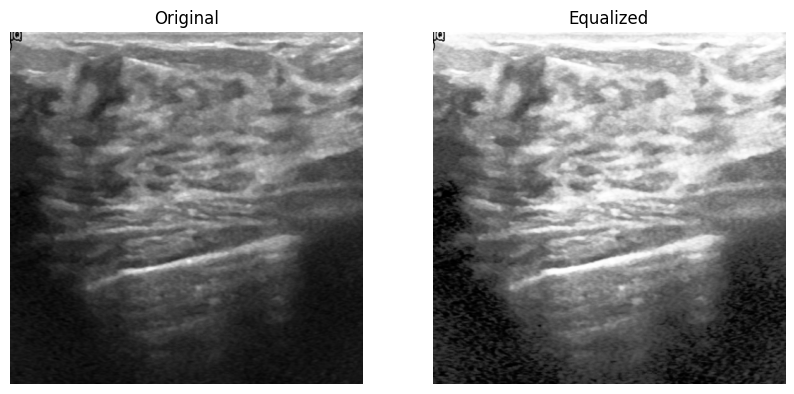

In [70]:
img_path = '../DATA/raw/normal/normal (1).png'

result = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
result = img_preprocess(result)
img_hist_eq = cv2.equalizeHist(result)

print(evaluate_metrics(result, img_hist_eq))
show_side_by_side(result, img_hist_eq, "Original", "Equalized")

# Experiments

Experiment: Histogram Equalization
	Processing Time: 0.0014 s
	RMSE: 50.5399
	AMBE: 45.3113
	PSNR: 27.2236
	SSIM: 0.8077


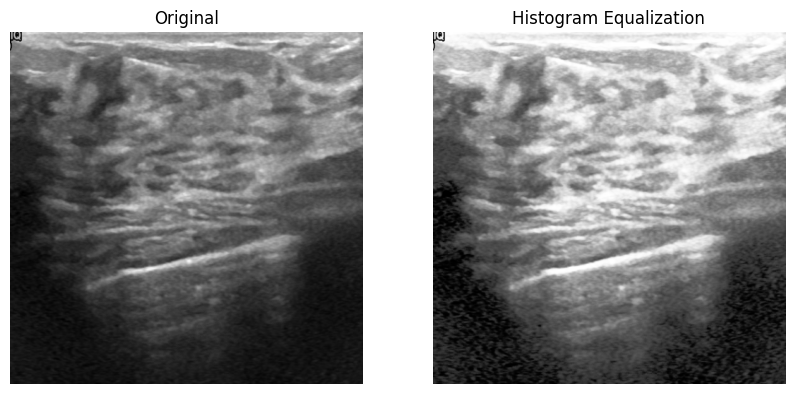

Experiment: Bilateral Filter
	Processing Time: 0.0051 s
	RMSE: 5.3351
	AMBE: 3.8565
	PSNR: 34.4897
	SSIM: 0.8613


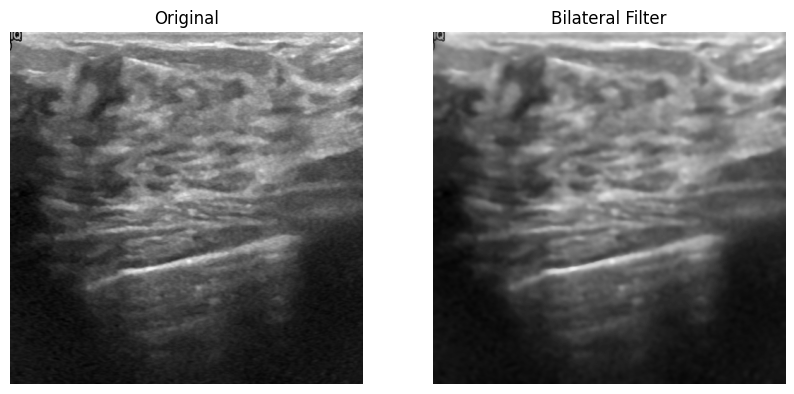

Experiment: CLAHE
	Processing Time: 0.0014 s
	RMSE: 77.5525
	AMBE: 62.6780
	PSNR: 27.8701
	SSIM: 0.4390


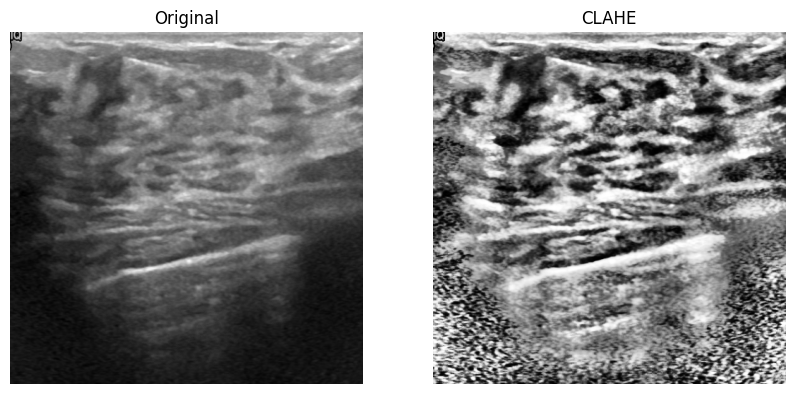

Experiment: Total Variation Denoise
	Processing Time: 0.7219 s
	RMSE: 97.9886
	AMBE: 83.2337
	PSNR: 8.3073
	SSIM: 0.0000


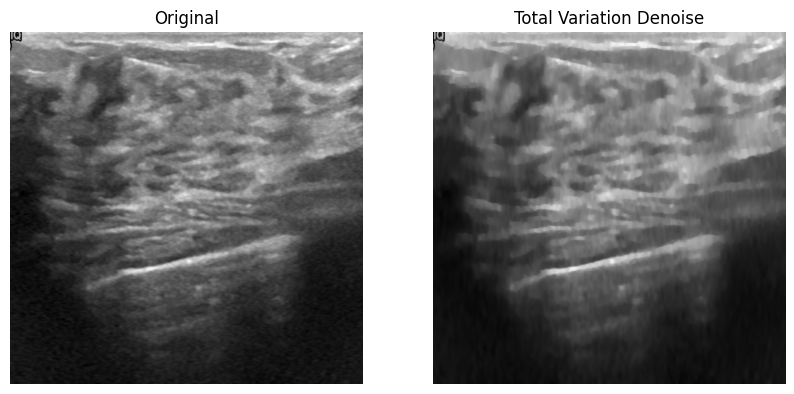

Experiment: Median Filter
	Processing Time: 0.0018 s
	RMSE: 3.9795
	AMBE: 2.1843
	PSNR: 38.4859
	SSIM: 0.9419


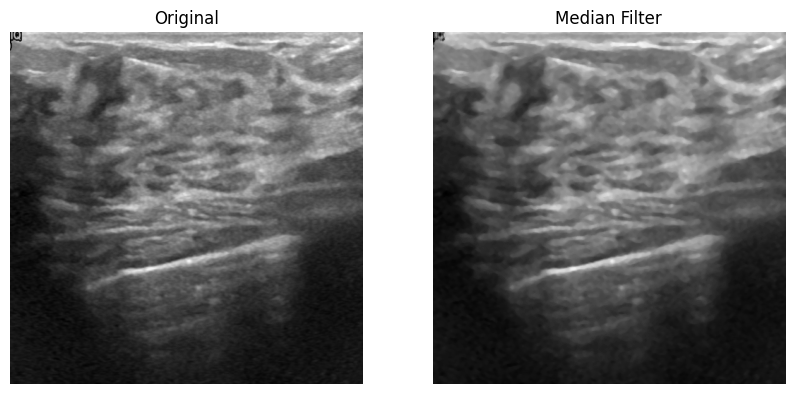

Experiment: Gaussian Filter
	Processing Time: 0.0006 s
	RMSE: 4.8344
	AMBE: 3.1293
	PSNR: 36.0482
	SSIM: 0.9154


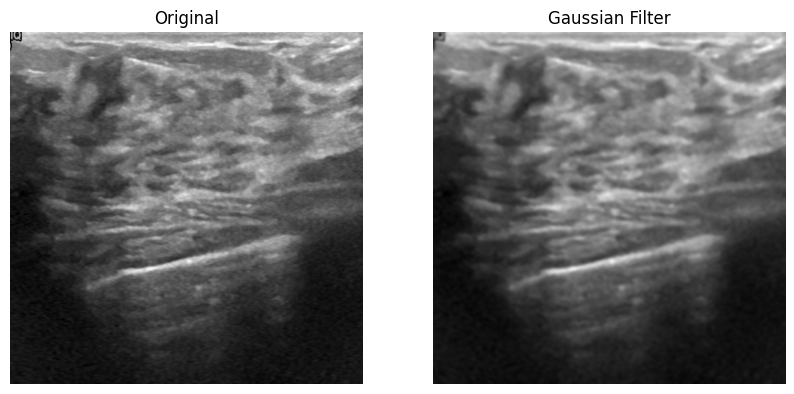

In [107]:
experiments = [
    ("Histogram Equalization", cv2.equalizeHist),
    ("Bilateral Filter", bilateral_filter),
    ("CLAHE", cv2.createCLAHE().apply),
    # ("LIME", lime_filter),
    ("Total Variation Denoise", total_variation_denoise),
    # ("Exposure Fusion", exposure_fusion_filter),
    ("Median Filter", median_blur),
    ("Gaussian Filter", gaussian_blur)
]

for name, process in experiments:
    print(f"Experiment: {name}")

    time = evaulate_time(result, process)
    print(f"\tProcessing Time: {time:.4f} s")

    #get all metrics
    metrics = evaluate_metrics(result, process(result))

    #print metrics
    print(f"\tRMSE: {metrics[0]:.4f}")
    print(f"\tAMBE: {metrics[1]:.4f}")
    print(f"\tPSNR: {metrics[2]:.4f}")
    print(f"\tSSIM: {metrics[3]:.4f}")



    show_side_by_side(result, process(result), "Original", name)